## TP 2 - Visión por Computadora 1

### Carrera de Especialización en Inteligencia Artificial - Cohorte 17

### Autora: Micozzi, María Luz - a1707

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: **“focus_video.mov”**.

1. Se debe implementar un algoritmo que, dada una imagen o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" y realizar tres experimentos:

   1. Medición sobre todo el frame.
   2. Medición sobre una ROI ubicada en el centro del frame. Área de la ROI = 5 o 10% del área total del frame.
   3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores (3x3, 7x5, etc…) (al menos 3).

Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detectó el punto de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

In [32]:
# imports
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### Funciones y definiciones generales

In [33]:
# path del video con el que vamos a trabajar
video_path = 'focus_video.mov'

# percentil que vamos a utilizar para determinar el rango de frames enfocados
threshold_percentile = 80

# trabajaremos con un ROI del 10%
roi_percentage = 0.1

In [34]:
# función para gráficar la evolución de la métrica correspondiete

def plot_metric_curve(metric_values: np.ndarray, metric_name: str, experiment: str) -> None:
    """
   Gráfica la evolución de una métrica determinada

    :param metric_values: Valores de la métrica
    :type metric_values: np.ndarray
    :param metric_name: Nombre de la métrica
    :type metric_name: str
    :param experiment: Experimento
    :type experiment: str
    """

    threshold = np.percentile(metric_values, threshold_percentile)

    # definimos el color según el threshold definido por el percentil
    colors = ['green' if mv > threshold else 'red' for mv in metric_values]

    plt.scatter(range(len(metric_values)), metric_values, c=colors, label=metric_name, alpha=0.6)

    plt.title(f"Image Quality Measure - {experiment}")
    plt.xlabel("Frame")
    plt.ylabel(metric_name)
    
    plt.show()

In [35]:
# función para generar y almacenar el video con las métricas

def create_video_with_metric(video_path: str, output_path: str, metric_values: list, metric_name: str, mark_ROI: bool = False, matrix_size: tuple = None) -> None:
    """
    Crea un nuevo video con los valores de la métrica mostrados en cada frame.
    
    :param video_path: Ruta al archivo de video
    :type video_path: str
    :param output_path: Ruta donde se guarda el archivo de video
    :type output_path: str
    :param metric_values: Valores de la métrica
    :type metric_values: np.ndarray
    :param metric_name: Nombre de la métrica
    :type metric_name: str
    :param mark_ROI: Indica si se quiere delimitar una ROI
    :type: bool
    :param matrix_size: Dimensiones de la matriz de enfoque
    :type matrix_size: tuple
    """
    threshold = np.percentile(metric_values, threshold_percentile)

    cap = cv.VideoCapture(video_path)
    fps = int(cap.get(cv.CAP_PROP_FPS))
    delay = int(600 / fps)
    
    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv.CAP_PROP_FPS))
    
    # creamos un objeto VideoWriter para guardar el nuevo video
    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    out = cv.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    frame_count = 0

    # recorremos cada frame del video y agregamos el texto de la métrica
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break

        # obtener el valor de la métrica para este frame
        value = metric_values[frame_count]
        frame_count += 1

        # definimos el color del marco o matriz según el threshold definido por el percentil
        if value <= threshold:
            color = (0, 0, 255)
        else:
            color = (0, 255, 0)
        
        # agregamos un texto con la métrica
        text = f"{metric_name}: {value:.4f}"
        cv.putText(frame, text, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv.LINE_AA)

        # marcamos la region
        if mark_ROI:
            x1, y1, x2, y2 = get_roi(frame, roi_percentage)
            cv.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        elif matrix_size is not None:
            frame = draw_matrix(frame, matrix_size, color)
        else:
            cv.rectangle(frame, (0, 0), (frame_width - 1, frame_height - 1), color, 2)

        # escribimos el frame modificado en el nuevo video
        out.write(frame)

         # Mostrar el frame combinado
        cv.imshow('Video', frame)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

    # liberamos el video y cerrarramos la ventana de OpenCV
    cap.release()
    out.release()
    cv.destroyAllWindows()

In [36]:
# función para obtener una ROI

def get_roi(image: np.ndarray, roi_percentage: float = 0.1) -> tuple:
    """
    Obtiene una región de interés (ROI) de la imagen.
    
    :param image: Imagen de entrada
    :type image: numpy.ndarray
    :param roi_percentage: Porcentaje de la imagen que se usará como ROI
    :type roi_percentage: float
    :return: x1, y1, x2, y2 de la ROI
    :rtype: tuple
    """
    height, width = image.shape[:2]
    
    roi_percentage = np.sqrt(roi_percentage)
    
    # calculamos las dimensiones de la ROI
    roi_height = int(height * roi_percentage)
    roi_width = int(width * roi_percentage)
    
    # calculamos las coordenadas de la ROI centrada
    y1 = height // 2 - roi_height // 2
    y2 = y1 + roi_height
    x1 = width // 2 - roi_width // 2
    x2 = x1 + roi_width
    
    return (x1, y1, x2, y2)

In [37]:
# funcion para devolver la medida de calidad para cada frame del video

def calculate_video_quality_measure(video_path: str, metric_func: callable, apply_unsharp_masking: bool = False, roi_percentage: float = 1.0) -> list:

    """
    Devuelve la medida de calidad para cada frame del video

    :param video_path: Ruta al archivo de video
    :type video_path: str
    :param metric_func: Función para calcular la métrica
    :type metric_func: callable
    :param apply_unsharp_masking: Indica si queremos aplicar unsharp masking
    :type apply_unsharp_masking: bool
    :param roi_percentage: Porcentaje de la imagen que se usará como ROI
    :type roi_percentage: float
    """
    
    cap = cv.VideoCapture(video_path)
    
    metric_values = []

    # recorremos cada frame del video calculando la métrica indicada
    while True:
        
        ret, frame = cap.read()
        
        if not ret:
            break

        if apply_unsharp_masking:
            frame = unsharp_masking(frame)
        
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # obtenemos la ROI        
        x1, y1, x2, y2 = get_roi(gray_frame, roi_percentage)
        roi = gray_frame[y1:y2, x1:x2]

        # aplicamos y almacenamos la métrica para el frame
        value = metric_func(roi)
        metric_values.append(value)

    # liberamos el video y cerrarramos la ventana de OpenCV
    cap.release()
    cv.destroyAllWindows()
    
    return metric_values

### Implementación del algoritmo indicado en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain"

In [38]:
def calculate_image_quality_measure_FM(I: np.ndarray) -> float:
    """
    Calcula la medida de calidad de una imagen (FM) en el dominio de la frecuencia.

    :param I: Imagen de tamaño MxN
    :type I: np.ndarray
    :returns: La medida de calidad de la imagen (FM). Valor entre 0 y 1. Un valor más alto indica una imagen con mayor calidad en el dominio de frecuencia
    :rtype: float
    """
    
    # Step 1: Compute F which is the Fourier Transform representation of image I
    F = np.fft.fft2(I)

    # Step 2: Find Fc which is obtained by shifting the origin of F to centre.
    Fc = np.fft.fftshift(F)

    # Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    AF = np.abs(Fc)

    # Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    M = np.max(AF)

    # Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000
    thres = M / 1000
    TH = np.sum(AF > thres)

    # Step 6: Calculate Image Quality measure (FM). FM = TH / (M X N)
    M, N = I.shape
    FM = TH / (M * N)

    return FM

### Experimento 1: Medición sobre todo el frame - FM

In [39]:
# función para medición sobre todo el frame, generar el nuevo video y gráficar

def run_first_experiment(video_path: str, metric_name: str, metric_func: callable, apply_unsharp_masking: bool = False) -> None:

    """
    Realiza el experimento sobre todo el frame

    :param video_path: Ruta al archivo de video
    :type video_path: str
    :param metric_name: Nombre de la métrica
    :type metric_name: str
    :param metric_func: Función para calcular la métrica
    :type metric_func: callable
    :param apply_unsharp_masking: Indica si queremos aplicar unsharp masking
    :type apply_unsharp_masking: bool
    """

    # obtenemos las metricas para el video
    metric_values = calculate_video_quality_measure(video_path, metric_func, apply_unsharp_masking)

    # creamos el video con la métrica
    output_path = f"Outputs/{metric_name}_frameCompleto.mov"
    create_video_with_metric(video_path, output_path, metric_values, metric_name)
    
    # mostramos un gráfico con la evolución de la métrica correspondiente
    plot_metric_curve(metric_values, metric_name, 'Full Frame')

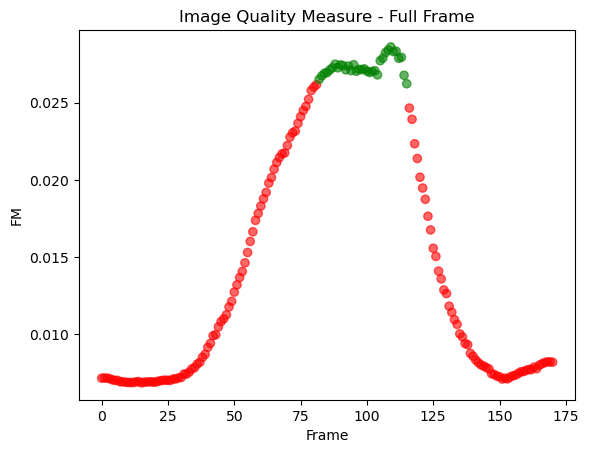

In [40]:
# corremos el primer experimento para la métrica FM
run_first_experiment(video_path, 'FM', calculate_image_quality_measure_FM)

### Experimento 2: Medición sobre una ROI (10%) - FM

In [41]:
# función para medición sobre una ROI, generar el nuevo video y gráficar

def run_second_experiment(video_path: str, metric_name: str, metric_func: callable, roi_percentage: float = roi_percentage, apply_unsharp_masking: bool = False) -> None:

    """
    Realiza el experimento sobre una ROI

    :param video_path: Ruta al archivo de video
    :type video_path: str
    :param metric_name: Nombre de la métrica
    :type metric_name: str
    :param metric_func: Función para calcular la métrica
    :type metric_func: callable
    :param roi_percentage: Porcentaje de la imagen que se usará como ROI
    :type roi_percentage: float
    :param apply_unsharp_masking: Indica si queremos aplicar unsharp masking
    :type apply_unsharp_masking: bool
    """
    # obtenemos las metricas para la roi indicada
    metric_values = calculate_video_quality_measure(video_path, metric_func, apply_unsharp_masking, roi_percentage=roi_percentage)

    # creamos el video con la métrica
    output_path = f"Outputs/{metric_name}_roi.mov"
    create_video_with_metric(video_path, output_path, metric_values, metric_name, mark_ROI=True)
    
    # mostramos un gráfico con la evolución de la métrica correspondiente
    plot_metric_curve(metric_values, metric_name, 'ROI 10%')

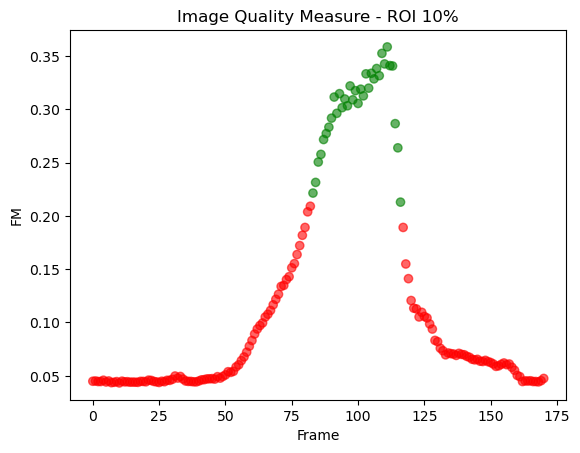

In [42]:
# corremos el segundo experimento para la métrica FM
run_second_experiment(video_path, 'FM', calculate_image_quality_measure_FM)

### Experimento 3: Medición sobre una matriz de enfoque - FM

In [43]:
# función para dibujar la matriz de enfoque sobre un frame

def draw_matrix(image: np.ndarray, matrix_size: tuple , color: tuple) -> np.ndarray:
    """
    Dado un frame, dibuja una matriz de enfoque y devuelve el resultado

    :param image: Frame original
    :type image: np.ndarray
    :param matrix_size: Dimensiones de la matriz de enfoque
    :type matrix_size: tuple
    :param color: color de la matriz a dibujar
    :type color: tuple
    :return: Frame modificado con la matriz de enfoque dibujada
    :rtype: np.ndarray
    """
    n, m = matrix_size
    spacing = 10
    height, width = image.shape[:2]
    area = height * width

    total_element_area = roi_percentage * area # centramos la matriz en una ROI del 10%

    element_side = int(np.sqrt(total_element_area / (n * m)))

    total_matrix_width = m * element_side + (m - 1) * spacing
    total_matrix_height = n * element_side + (n - 1) * spacing

    start_x = (width - total_matrix_width) // 2
    start_y = (height - total_matrix_height) // 2

    # dibujamos los cuadrados con el color correspondiente
    for i in range(n):
        for j in range(m):
            x_start = start_x + j * (element_side + spacing)
            y_start = start_y + i * (element_side + spacing)
            x_end = x_start + element_side
            y_end = y_start + element_side

            if x_end < width and y_end < height:
                cv.rectangle(image, (x_start, y_start), (x_end, y_end), color, 2)

    return image

In [44]:
# función para calcular la métrica de calidad sobre una matriz de enfoque en una imagen

def calculate_image_quality_measure_to_matrix(image: np.ndarray, metric_func: callable, matrix_size: tuple) -> list:
    """
    Dada una imagen calcula la métrica asignada para una matriz de enfoque de NXM

    :param image: Imagen
    :type image: np.ndarray
    :param metric_func: Función para calcular la métrica
    :type metric_func: callable
    :param matrix_size: Dimensiones de la matriz de enfoque
    :type matrix_size: tuple
    :return: Calidad de imagen calculada para cada cuadrado de la matriz
    :rtype: list
    """
    n, m = matrix_size
    spacing = 10
    height, width = image.shape[:2]
    area = height * width

    total_element_area = roi_percentage * area # centramos la matriz en una ROI del 10%

    element_side = int(np.sqrt(total_element_area / (n * m)))

    total_matrix_width = m * element_side + (m - 1) * spacing
    total_matrix_height = n * element_side + (n - 1) * spacing

    metric_values = []
    
    start_x = (width - total_matrix_width) // 2
    start_y = (height - total_matrix_height) // 2

    for i in range(n):
        for j in range(m):
            x_start = start_x + j * (element_side + spacing)
            y_start = start_y + i * (element_side + spacing)
            x_end = x_start + element_side
            y_end = y_start + element_side

            if x_end < width and y_end < height:
                roi = image[y_start:y_end, x_start:x_end]
                
                # calcula la métrica para el cuadrado
                value = metric_func(roi)
                metric_values.append(value)
    
    return metric_values

In [45]:
# función para medición sobre una matriz de enfoque NXM, generar el nuevo video y gráficar

def run_third_experiment(video_path: str, metric_name: str, metric_func: callable, matrix_size: tuple) -> None:

    """
    Realiza el experimento sobre una matriz de enfoque NXM

    :param video_path: Ruta al archivo de video
    :type video_path: str
    :param metric_name: Nombre de la métrica
    :type metric_name: str
    :param metric_func: Función para calcular la métrica
    :type metric_func: callable
    :param matrix_size: Dimensiones de la matriz de enfoque
    :type matrix_size: tuple
    """
    
    cap = cv.VideoCapture(video_path)
    
    mean_metric_values = []

    # recorremos cada frame del video calculando la métrica indicada
    while True:
        
        ret, frame = cap.read()
        
        if not ret:
            break

        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # aplicamos y almacenamos la métrica para el frame
        matrix_measure = calculate_image_quality_measure_to_matrix(gray_frame, metric_func, matrix_size)
        
        mean_measure = np.mean(matrix_measure) # obtenemos la media de la metrica para la matriz        
        mean_metric_values.append(mean_measure)

    # liberamos el video y cerrarramos la ventana de OpenCV
    cap.release()
    cv.destroyAllWindows()

    # creamos el video con la métrica
    n = matrix_size[0]
    m = matrix_size[1]
    output_path = f"Outputs/{metric_name}_matrix_{n}x{m}.mov"
    create_video_with_metric(video_path, output_path, mean_metric_values, metric_name, matrix_size=matrix_size)

    # mostramos un gráfico con la evolución de la métrica correspondiente
    plot_metric_curve(mean_metric_values, metric_name, f'Matrix {n}x{m}')

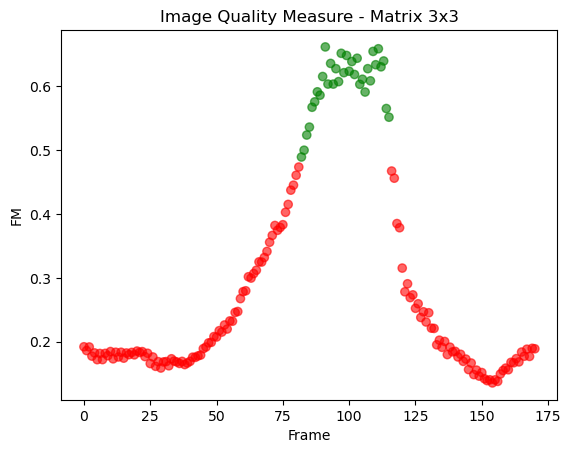

In [46]:
# corremos el tercer experimento para la métrica FM para una matriz de enfoque de 3x3
run_third_experiment(video_path, 'FM', calculate_image_quality_measure_FM, (3,3))

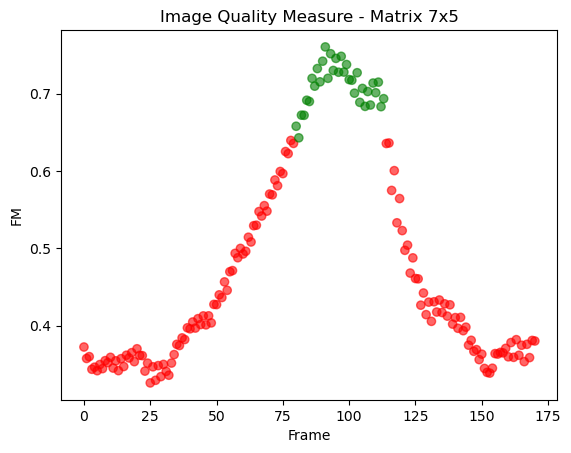

In [47]:
# corremos el tercer experimento para la métrica FM para una matriz de enfoque de 7x5
run_third_experiment(video_path, 'FM', calculate_image_quality_measure_FM, (7,5))

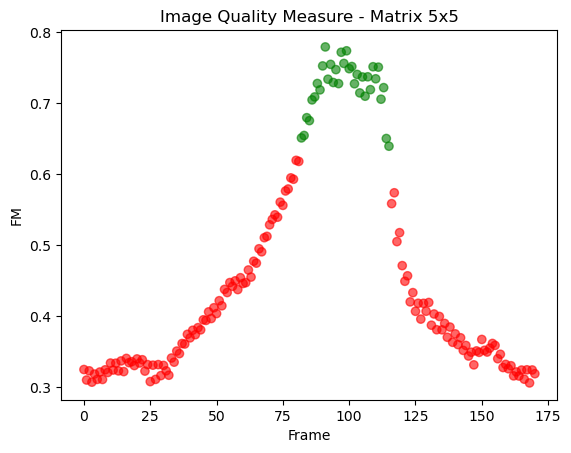

In [48]:
# corremos el tercer experimento para la métrica FM para una matriz de enfoque de 5x5
run_third_experiment(video_path, 'FM', calculate_image_quality_measure_FM, (5,5))

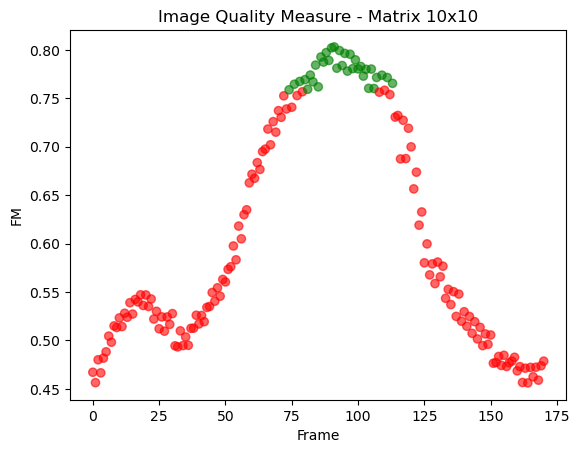

In [49]:
# corremos el tercer experimento para la métrica FM para una matriz de enfoque de 10x10
run_third_experiment(video_path, 'FM', calculate_image_quality_measure_FM,  (10,10))

### Implementación del algoritmo "Absolut Central Moment" (MIS1)

In [50]:
def calculate_image_quality_measure_MIS1(image: np.ndarray) -> float:
    
    """
    Calcula el Absolut Central Moment (MIS1)

    :param image: Imagen
    :type image: np.ndarray
    :returns: Valor del momento central absoluto (ACMo)
    :rtype: float    
    """
   # obtenemos el histograma de la imagen
    hist, bin_edges = np.histogram(image, bins=256, range=(0, 255))
    
    # normalizamos el histograma para obtener las frecuencias relativas
    total_pixels = image.size
    relative_frequencies = hist / total_pixels
    
    # calculamamos la media de intensidad
    mean_intensity = np.sum(bin_edges[:-1] * relative_frequencies)
    
    # calculamos el momento absoluto central (ACMo)
    ACMo = np.sum(np.abs(bin_edges[:-1] - mean_intensity) * relative_frequencies)    

    return ACMo

### Experimento 1: Medición sobre todo el frame - MIS1

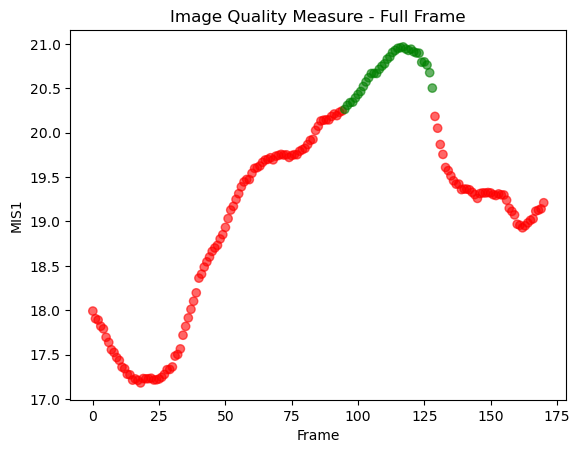

In [51]:
# corremos el primer experimento para la métrica MIS1
run_first_experiment(video_path, 'MIS1', calculate_image_quality_measure_MIS1)

### Experimento 2: Medición sobre una ROI (10%) - MIS1

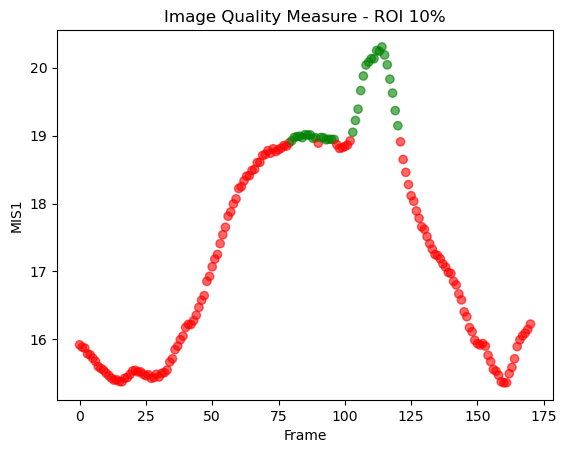

In [52]:
# corremos el segundo experimento para la métrica MIS1
run_second_experiment(video_path, 'MIS1', calculate_image_quality_measure_MIS1)

### Experimento 3: Medición sobre una matriz de enfoque - MIS1

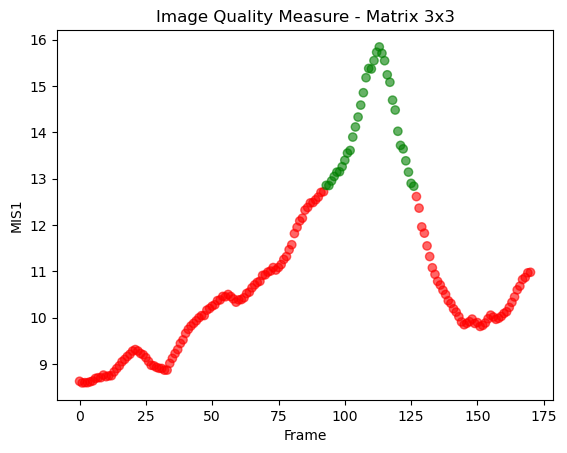

In [53]:
# corremos el tercer experimento para la métrica MIS1 para una matriz de enfoque de 3x3
run_third_experiment(video_path, 'MIS1', calculate_image_quality_measure_MIS1, (3,3))

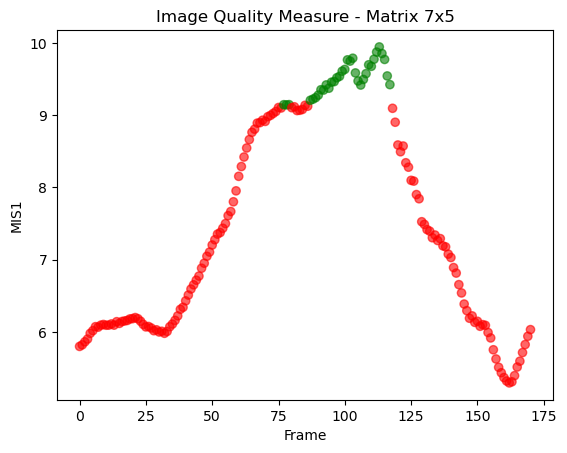

In [54]:
# corremos el tercer experimento para la métrica MIS1 para una matriz de enfoque de 7x5
run_third_experiment(video_path, 'MIS1', calculate_image_quality_measure_MIS1, (7,5))

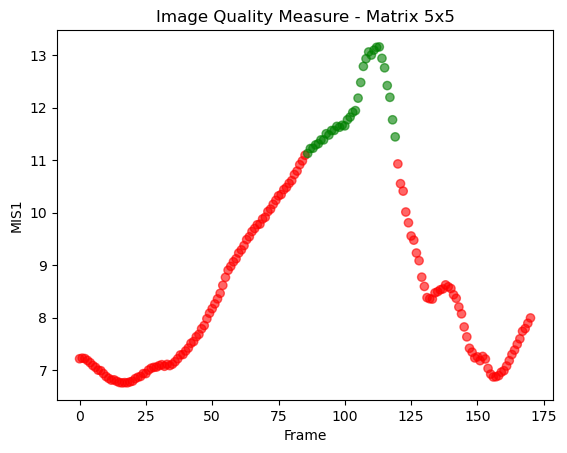

In [55]:
# corremos el tercer experimento para la métrica MIS1 para una matriz de enfoque de 5x5
run_third_experiment(video_path, 'MIS1', calculate_image_quality_measure_MIS1, (5,5))

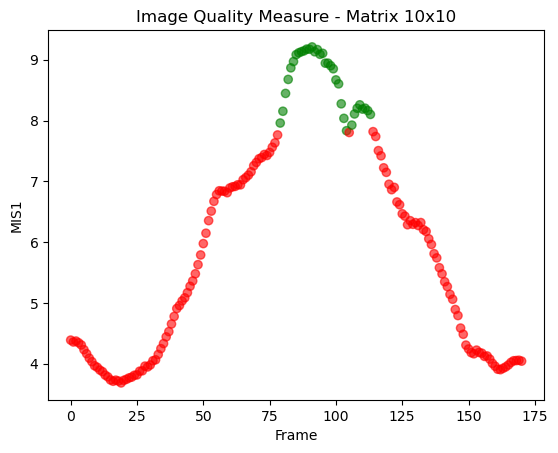

In [56]:
# corremos el tercer experimento para la métrica MIS1 para una matriz de enfoque de 10x10
run_third_experiment(video_path, 'MIS1', calculate_image_quality_measure_MIS1,  (10,10))

### Aplicación de unsharp masking

In [57]:
def unsharp_masking(image: np.array, sigma: float = 1.0) -> np.array:
    k = 5.0

    # se suaviza la imagen utilizando un filtro gaussiano
    gauss = cv.GaussianBlur(image, (0, 0), sigma)
    
    # aplicar la máscara de enfoque
    new_image = cv.addWeighted(image, k + 1, gauss, -k, 0)
    
    return new_image

Repetimos los experimentos para la métrica FM aplicando unsharp masking

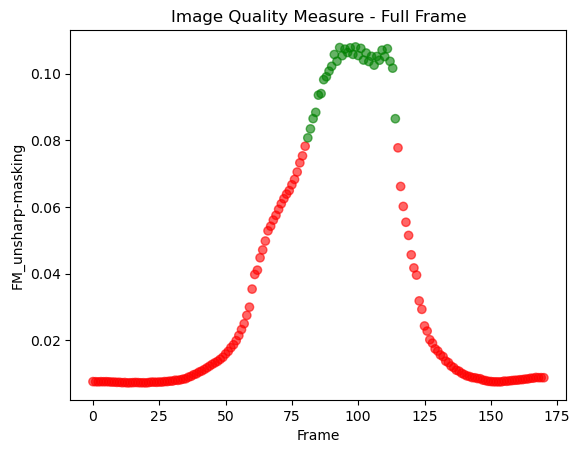

In [58]:
# corremos el primer experimento (todo el frame) para la métrica FM usando unsharp masking
run_first_experiment(video_path, 'FM_unsharp-masking', calculate_image_quality_measure_FM, apply_unsharp_masking=True)

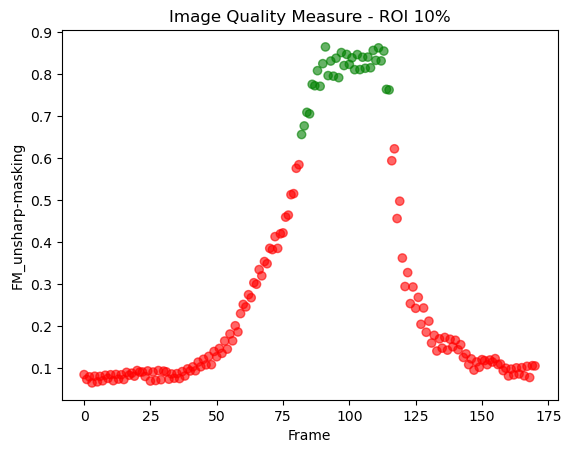

In [59]:
# corremos el segundo experimento (ROI 10%) para la métrica FM usando unsharp masking
run_second_experiment(video_path, 'FM_unsharp-masking', calculate_image_quality_measure_FM, apply_unsharp_masking=True)

#### Comparación de resultados con unsharp masking

In [60]:
metric_values_full_frame = calculate_video_quality_measure(video_path, calculate_image_quality_measure_FM)
metric_values_full_frame_unsharp_masking = calculate_video_quality_measure(video_path, calculate_image_quality_measure_FM, apply_unsharp_masking=True)
metric_values_roi = calculate_video_quality_measure(video_path, calculate_image_quality_measure_FM, roi_percentage=roi_percentage)
metric_values_roi_unsharp_masking = calculate_video_quality_measure(video_path, calculate_image_quality_measure_FM, roi_percentage=roi_percentage, apply_unsharp_masking=True)

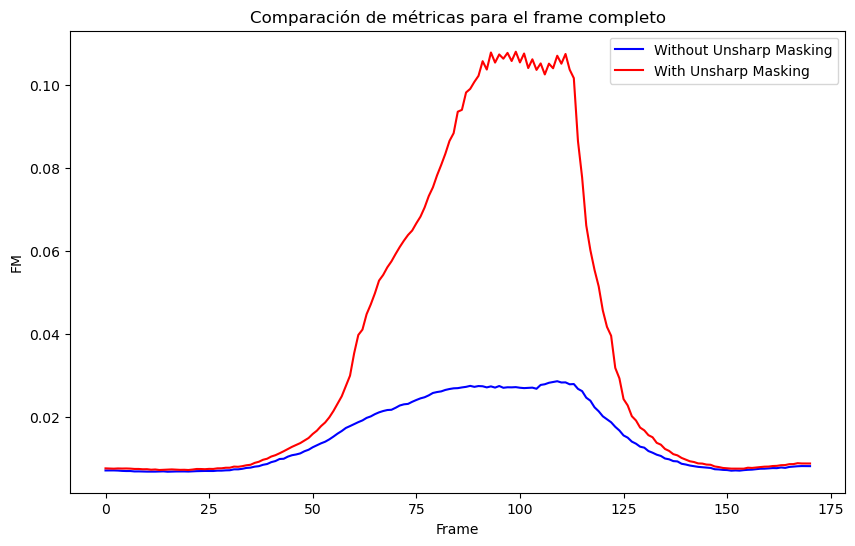

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(metric_values_full_frame, label='Without Unsharp Masking', color='b')
plt.plot(metric_values_full_frame_unsharp_masking, label='With Unsharp Masking', color='r')
plt.xlabel('Frame')
plt.ylabel('FM')
plt.title('Comparación de métricas para el frame completo')

plt.legend()
plt.show()

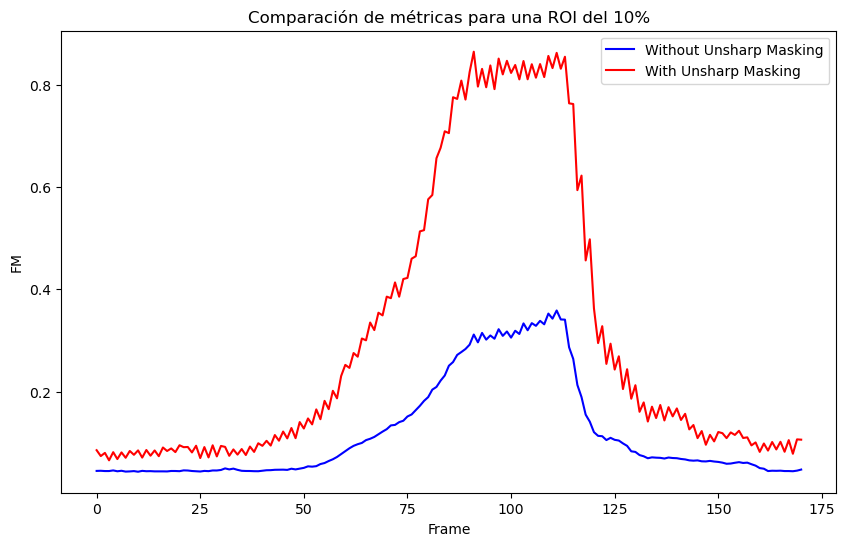

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(metric_values_roi, label='Without Unsharp Masking', color='b')
plt.plot(metric_values_roi_unsharp_masking, label='With Unsharp Masking', color='r')
plt.xlabel('Frame')
plt.ylabel('FM')
plt.title('Comparación de métricas para una ROI del 10%')

plt.legend()
plt.show()

En ambos experimentos, frame completo y ROI del 10%, podemos notar una gran mejora en la calidad de la imagen (FM) luego de aplicar el método unsharp masking, demostrando así su eficiencia a la hora de mejorar la nitidez de una imagen